In [11]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Device count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")



CUDA is available!
Device count: 1
Device 0: NVIDIA TITAN RTX


Epoch 1/50, Train Loss: 0.2658, Val Loss: 0.0818, Val Accuracy: 97.50%
Epoch 2/50, Train Loss: 0.1126, Val Loss: 0.0527, Val Accuracy: 98.36%
Epoch 3/50, Train Loss: 0.0874, Val Loss: 0.0475, Val Accuracy: 98.62%
Epoch 4/50, Train Loss: 0.0782, Val Loss: 0.0457, Val Accuracy: 98.69%
Epoch 5/50, Train Loss: 0.0639, Val Loss: 0.0677, Val Accuracy: 98.43%
Epoch 6/50, Train Loss: 0.0610, Val Loss: 0.0358, Val Accuracy: 98.96%
Epoch 7/50, Train Loss: 0.0514, Val Loss: 0.0334, Val Accuracy: 99.08%
Epoch 8/50, Train Loss: 0.0498, Val Loss: 0.0351, Val Accuracy: 98.99%
Epoch 9/50, Train Loss: 0.0370, Val Loss: 0.0278, Val Accuracy: 99.13%
Epoch 10/50, Train Loss: 0.0371, Val Loss: 0.0373, Val Accuracy: 99.02%
Epoch 11/50, Train Loss: 0.0265, Val Loss: 0.0249, Val Accuracy: 99.33%
Epoch 12/50, Train Loss: 0.0251, Val Loss: 0.0293, Val Accuracy: 99.24%
Epoch 13/50, Train Loss: 0.0226, Val Loss: 0.0260, Val Accuracy: 99.36%
Epoch 14/50, Train Loss: 0.0202, Val Loss: 0.0285, Val Accuracy: 99.18%
E

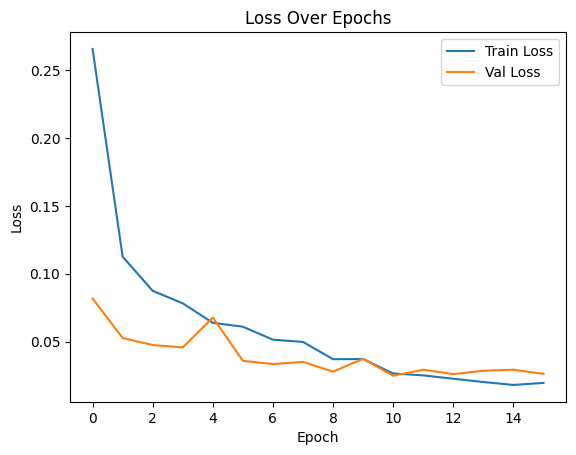

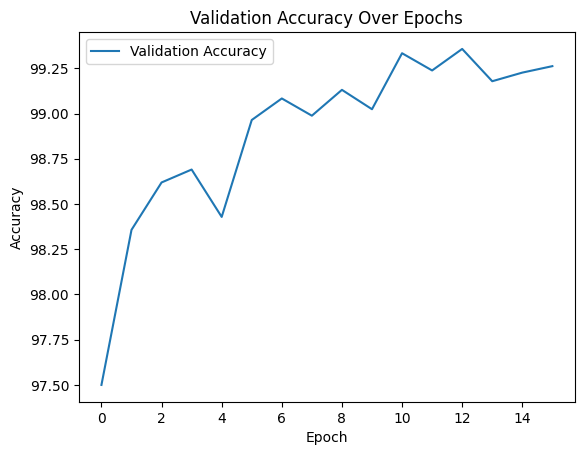

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms

# データの読み込み
train = pd.read_csv('/home/suzukilab/kaggle/mnist/data/train.csv')
test = pd.read_csv('/home/suzukilab/kaggle/mnist/data/test.csv')

# 特徴量とラベルに分割
X = train.drop('label', axis=1).values
y = train['label'].values

# データの前処理
X = X.reshape(-1, 28, 28).astype('float32') / 255.0
X_test = test.values.reshape(-1, 28, 28).astype('float32') / 255.0

# ラベルのエンコード
y = torch.tensor(y, dtype=torch.long)
X_train_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # チャネル次元を追加
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

# 学習・検証データの分割
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y, test_size=0.2, random_state=42)

# データ拡張の設定
transform = transforms.Compose([
    transforms.RandomRotation(10),  # 画像をランダムに回転
    transforms.RandomHorizontalFlip(),  # 画像をランダムに左右反転
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# DataLoaderの作成
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

# CNNモデルの定義
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)
        
        # バッチ正規化層を追加
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# モデル、損失関数、最適化手法
model = CNNModel().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習率スケジューラー
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Early Stoppingの設定
best_val_loss = float('inf')
patience = 5  # 損失が改善しない最大エポック数
counter = 0  # 改善がないエポック数

# 学習の実行
epochs = 50
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # バリデーション
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
    
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    
    # Early Stoppingのチェック
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # 改善があったのでカウントをリセット
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping...")
            break
    
    # 学習率の更新
    scheduler.step()

# 学習結果のプロット
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 予測
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.cuda())
    predicted_labels = predictions.argmax(dim=1).cpu().numpy()

# 予測結果の保存
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(predicted_labels) + 1),
    "Label": predicted_labels
})
submission.to_csv('/home/suzukilab/kaggle/mnist/submission.csv', index=False)